### Building the ResNet Model Architeture From Scratch

In [3]:
import torch
import torch.nn as nn
import pathlib
import numpy as np
from IPython.display import Image

import torchvision
from torchview import draw_graph

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class Bottleneck(nn.Module):

    def __init__(self,in_channels,intermediate_channels,expansion,is_Bottleneck,stride):
        
        super(Bottleneck,self).__init__()

        self.expansion = expansion
        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        self.is_Bottleneck = is_Bottleneck
        
        if self.in_channels==self.intermediate_channels*self.expansion:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=stride, padding=0, bias=False ))
            projection_layer.append(nn.BatchNorm2d(self.intermediate_channels*self.expansion))
            self.projection = nn.Sequential(*projection_layer)

        self.relu = nn.ReLU()

         
        if self.is_Bottleneck:
             
            self.conv1_1x1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False )
            self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
            
            self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
            self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)
            
            self.conv3_1x1 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False )
            self.batchnorm3 = nn.BatchNorm2d( self.intermediate_channels*self.expansion )
        
        else:
    
            self.conv1_3x3 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
            self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
            
            self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False )
            self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

    def forward(self,x):
         
        in_x = x

        if self.is_Bottleneck:
            # conv1x1->BN->relu
            x = self.relu(self.batchnorm1(self.conv1_1x1(x)))
            
            # conv3x3->BN->relu
            x = self.relu(self.batchnorm2(self.conv2_3x3(x)))
            
            # conv1x1->BN
            x = self.batchnorm3(self.conv3_1x1(x))
        
        else:
            # conv3x3->BN->relu
            x = self.relu(self.batchnorm1(self.conv1_3x3(x)))

            # conv3x3->BN
            x = self.batchnorm2(self.conv2_3x3(x))


        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)

        # final relu
        x = self.relu(x)
        
        return x

def test_Bottleneck():
    x = torch.randn(1,64,112,112)
    model = Bottleneck(64,64,4,True,2)
    print(model(x).shape)
    del model

test_Bottleneck()

torch.Size([1, 256, 56, 56])


In [5]:
class ResNet(nn.Module):

    def __init__(self, resnet_variant,in_channels,num_classes):
         
        super(ResNet,self).__init__()
        self.channels_list = resnet_variant[0]
        self.repeatition_list = resnet_variant[1]
        self.expansion = resnet_variant[2]
        self.is_Bottleneck = resnet_variant[3]

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.block1 = self._make_blocks( 64 , self.channels_list[0], self.repeatition_list[0], self.expansion, self.is_Bottleneck, stride=1 )
        self.block2 = self._make_blocks( self.channels_list[0]*self.expansion , self.channels_list[1], self.repeatition_list[1], self.expansion, self.is_Bottleneck, stride=2 )
        self.block3 = self._make_blocks( self.channels_list[1]*self.expansion , self.channels_list[2], self.repeatition_list[2], self.expansion, self.is_Bottleneck, stride=2 )
        self.block4 = self._make_blocks( self.channels_list[2]*self.expansion , self.channels_list[3], self.repeatition_list[3], self.expansion, self.is_Bottleneck, stride=2 )

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear( self.channels_list[3]*self.expansion , num_classes)



    def forward(self,x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        
        x = self.block4(x)
        
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        
        return x

    def _make_blocks(self,in_channels,intermediate_channels,num_repeat, expansion, is_Bottleneck, stride):
        
        
        layers = [] 

        layers.append(Bottleneck(in_channels,intermediate_channels,expansion,is_Bottleneck,stride=stride))
        for num in range(1,num_repeat):
            layers.append(Bottleneck(intermediate_channels*expansion,intermediate_channels,expansion,is_Bottleneck,stride=1))

        return nn.Sequential(*layers)


def test_ResNet(params):
    model = ResNet( params , in_channels=3, num_classes=1000)
    x = torch.randn(1,3,224,224)
    output = model(x)
    print(output.shape)
    return model

model_parameters={}
model_parameters['resnet18'] = ([64,128,256,512],[2,2,2,2],1,False)
model_parameters['resnet34'] = ([64,128,256,512],[3,4,6,3],1,False)
model_parameters['resnet50'] = ([64,128,256,512],[3,4,6,3],4,True)
model_parameters['resnet101'] = ([64,128,256,512],[3,4,23,3],4,True)
model_parameters['resnet152'] = ([64,128,256,512],[3,8,36,3],4,True)

architecture = 'resnet50'
model = test_ResNet(model_parameters[architecture])


torch.Size([1, 1000])


In [4]:
# Compare layer-by-layer with PyTorch's implementation
from torchvision.models import resnet50
official_model = resnet50(pretrained=True)

# Compare parameter counts
print(sum(p.numel() for p in official_model.parameters()))
print(sum(p.numel() for p in model.parameters()))

c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


25557032
25557032


## Pretraining on Tiny ImageNet Dataset 

In [5]:
# Downloading the dataset

import kagglehub

# Download latest version
path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

print("Path to dataset files:", path)

c:\Users\gokul\anaconda3\envs\hello\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\gokul\.cache\kagglehub\datasets\akash2sharma\tiny-imagenet\versions\1


In [6]:
# Loading the dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pathlib

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dir= pathlib.Path(path) / 'tiny-imagenet-200/train'
val_dir=pathlib.Path(path) / 'tiny-imagenet-200/val'
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [7]:
num_classes=len(train_dataset.classes)
num_epochs=20
learning_rate=0.0001

model= ResNet(model_parameters['resnet50'], in_channels=3, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
from tqdm import tqdm
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='resnet_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score :
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda',path='resnet_model.pth'):
    model.to(device)
    early_stopping = EarlyStopping(patience=5, verbose=True, path=path)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss /= train_total
        train_acc = 100 * train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        print(f"\nEpoch {epoch+1} Results:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%\n")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break


In [9]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, path='resnet50_model.pth')

Epoch 1/20 - Validation: 100%|██████████| 313/313 [00:31<00:00,  9.95it/s]



Epoch 1 Results:
Train Loss: 4.7734 | Train Acc: 5.35%
Val   Loss: 4.2366 | Val   Acc: 10.73%

Validation loss decreased (inf → 4.236628). Saving model ...


Epoch 2/20 - Validation: 100%|██████████| 313/313 [00:32<00:00,  9.76it/s]



Epoch 2 Results:
Train Loss: 3.8995 | Train Acc: 15.32%
Val   Loss: 4.0753 | Val   Acc: 18.92%

Validation loss decreased (4.236628 → 4.075331). Saving model ...


Epoch 3/20 - Validation: 100%|██████████| 313/313 [00:38<00:00,  8.16it/s]



Epoch 3 Results:
Train Loss: 3.3782 | Train Acc: 23.37%
Val   Loss: 3.3096 | Val   Acc: 25.48%

Validation loss decreased (4.075331 → 3.309615). Saving model ...


Epoch 4/20 - Validation: 100%|██████████| 313/313 [00:34<00:00,  9.15it/s]



Epoch 4 Results:
Train Loss: 2.9819 | Train Acc: 30.30%
Val   Loss: 3.2399 | Val   Acc: 29.17%

Validation loss decreased (3.309615 → 3.239894). Saving model ...


Epoch 5/20 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.83it/s]



Epoch 5 Results:
Train Loss: 2.6140 | Train Acc: 37.35%
Val   Loss: 2.9931 | Val   Acc: 31.78%

Validation loss decreased (3.239894 → 2.993128). Saving model ...


Epoch 6/20 - Validation: 100%|██████████| 313/313 [00:27<00:00, 11.27it/s]



Epoch 6 Results:
Train Loss: 2.2307 | Train Acc: 44.87%
Val   Loss: 2.9207 | Val   Acc: 33.93%

Validation loss decreased (2.993128 → 2.920680). Saving model ...


Epoch 7/20 - Validation: 100%|██████████| 313/313 [00:26<00:00, 11.84it/s]



Epoch 7 Results:
Train Loss: 1.8164 | Train Acc: 53.45%
Val   Loss: 3.1996 | Val   Acc: 33.10%

EarlyStopping counter: 1 / 5


Epoch 8/20 - Validation: 100%|██████████| 313/313 [00:29<00:00, 10.53it/s]



Epoch 8 Results:
Train Loss: 1.3767 | Train Acc: 63.17%
Val   Loss: 3.2179 | Val   Acc: 34.31%

EarlyStopping counter: 2 / 5


Epoch 9/20 - Validation: 100%|██████████| 313/313 [00:28<00:00, 11.15it/s]



Epoch 9 Results:
Train Loss: 0.9733 | Train Acc: 72.89%
Val   Loss: 3.3793 | Val   Acc: 33.05%

EarlyStopping counter: 3 / 5


Epoch 10/20 - Validation: 100%|██████████| 313/313 [00:31<00:00,  9.90it/s]



Epoch 10 Results:
Train Loss: 0.6878 | Train Acc: 80.13%
Val   Loss: 3.6849 | Val   Acc: 32.54%

EarlyStopping counter: 4 / 5


Epoch 11/20 - Validation: 100%|██████████| 313/313 [00:31<00:00,  9.94it/s]


Epoch 11 Results:
Train Loss: 0.5142 | Train Acc: 84.79%
Val   Loss: 4.0150 | Val   Acc: 31.74%

EarlyStopping counter: 5 / 5
Early stopping triggered.


## Pretraining on CIFAR-100 dataset

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))   
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [12]:
model = ResNet(model_parameters['resnet50'], in_channels=3, num_classes=200)  
model.load_state_dict(torch.load('resnet50_model.pth'))

model.fc1= nn.Linear(model.fc1.in_features, len(train_dataset.classes))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Bottleneck(
      (projection): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (conv1_1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3_1x1): Conv2d(64, 256, kernel_size=(1

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [14]:
train(model,train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, path='resnet50_model.pth')

Epoch 1/20 - Validation: 100%|██████████| 79/79 [00:23<00:00,  3.33it/s]



Epoch 1 Results:
Train Loss: 2.8289 | Train Acc: 29.32%
Val   Loss: 2.4118 | Val   Acc: 37.51%

Validation loss decreased (inf → 2.411781). Saving model ...


Epoch 2/20 - Validation: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]



Epoch 2 Results:
Train Loss: 2.1559 | Train Acc: 42.79%
Val   Loss: 2.2062 | Val   Acc: 42.08%

Validation loss decreased (2.411781 → 2.206189). Saving model ...


Epoch 3/20 - Validation: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]



Epoch 3 Results:
Train Loss: 1.8393 | Train Acc: 49.69%
Val   Loss: 2.2333 | Val   Acc: 43.87%

EarlyStopping counter: 1 / 5


Epoch 4/20 - Validation: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]



Epoch 4 Results:
Train Loss: 1.5880 | Train Acc: 56.00%
Val   Loss: 2.1767 | Val   Acc: 44.39%

Validation loss decreased (2.206189 → 2.176707). Saving model ...


Epoch 5/20 - Validation: 100%|██████████| 79/79 [00:23<00:00,  3.38it/s]



Epoch 5 Results:
Train Loss: 1.3605 | Train Acc: 61.86%
Val   Loss: 2.1269 | Val   Acc: 46.17%

Validation loss decreased (2.176707 → 2.126875). Saving model ...


Epoch 6/20 - Validation: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]



Epoch 6 Results:
Train Loss: 1.1433 | Train Acc: 67.31%
Val   Loss: 2.2853 | Val   Acc: 45.26%

EarlyStopping counter: 1 / 5


Epoch 7/20 - Validation: 100%|██████████| 79/79 [00:21<00:00,  3.61it/s]



Epoch 7 Results:
Train Loss: 0.9596 | Train Acc: 72.65%
Val   Loss: 2.2225 | Val   Acc: 46.06%

EarlyStopping counter: 2 / 5


Epoch 8/20 - Validation: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]



Epoch 8 Results:
Train Loss: 0.7880 | Train Acc: 77.47%
Val   Loss: 2.2609 | Val   Acc: 46.53%

EarlyStopping counter: 3 / 5


Epoch 9/20 - Validation: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]



Epoch 9 Results:
Train Loss: 0.6402 | Train Acc: 81.52%
Val   Loss: 2.3551 | Val   Acc: 46.79%

EarlyStopping counter: 4 / 5


Epoch 10/20 - Validation: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Epoch 10 Results:
Train Loss: 0.5155 | Train Acc: 85.11%
Val   Loss: 2.4909 | Val   Acc: 46.27%

EarlyStopping counter: 5 / 5
Early stopping triggered.


## Fine Tuning on Caltech-256 Dataset

In [15]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and validation datasets
train_dataset = ImageFolder('data/train', transform=transform)
val_dataset = ImageFolder('data/val', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = ResNet(model_parameters['resnet50'], in_channels=3, num_classes=100)  
model.load_state_dict(torch.load('resnet50_model.pth'))

model.fc1= nn.Linear(model.fc1.in_features, len(train_dataset.classes))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Bottleneck(
      (projection): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (conv1_1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3_1x1): Conv2d(64, 256, kernel_size=(1

In [18]:
learning_rate=0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device, path='resnet50_model.pth')

Epoch 1/20 - Validation: 100%|██████████| 195/195 [01:40<00:00,  1.95it/s]



Epoch 1 Results:
Train Loss: 4.1690 | Train Acc: 17.61%
Val   Loss: 3.8104 | Val   Acc: 22.16%

Validation loss decreased (inf → 3.810403). Saving model ...


Epoch 2/20 - Validation: 100%|██████████| 195/195 [00:45<00:00,  4.28it/s]



Epoch 2 Results:
Train Loss: 3.1411 | Train Acc: 31.27%
Val   Loss: 3.0862 | Val   Acc: 32.77%

Validation loss decreased (3.810403 → 3.086187). Saving model ...


Epoch 3/20 - Validation: 100%|██████████| 195/195 [00:48<00:00,  4.02it/s]



Epoch 3 Results:
Train Loss: 2.5817 | Train Acc: 40.71%
Val   Loss: 2.7719 | Val   Acc: 38.78%

Validation loss decreased (3.086187 → 2.771935). Saving model ...


Epoch 4/20 - Validation: 100%|██████████| 195/195 [00:42<00:00,  4.64it/s]



Epoch 4 Results:
Train Loss: 2.1319 | Train Acc: 49.43%
Val   Loss: 2.9099 | Val   Acc: 37.95%

EarlyStopping counter: 1 / 5


Epoch 5/20 - Validation: 100%|██████████| 195/195 [00:43<00:00,  4.45it/s]



Epoch 5 Results:
Train Loss: 1.7565 | Train Acc: 56.83%
Val   Loss: 2.5070 | Val   Acc: 43.39%

Validation loss decreased (2.771935 → 2.507011). Saving model ...


Epoch 6/20 - Validation: 100%|██████████| 195/195 [00:43<00:00,  4.49it/s]



Epoch 6 Results:
Train Loss: 1.3920 | Train Acc: 64.45%
Val   Loss: 2.5214 | Val   Acc: 43.92%

EarlyStopping counter: 1 / 5


Epoch 7/20 - Validation: 100%|██████████| 195/195 [00:44<00:00,  4.39it/s]



Epoch 7 Results:
Train Loss: 1.0125 | Train Acc: 73.75%
Val   Loss: 2.8468 | Val   Acc: 42.01%

EarlyStopping counter: 2 / 5


Epoch 8/20 - Validation: 100%|██████████| 195/195 [00:45<00:00,  4.30it/s]



Epoch 8 Results:
Train Loss: 0.6706 | Train Acc: 82.87%
Val   Loss: 2.8981 | Val   Acc: 44.37%

EarlyStopping counter: 3 / 5


Epoch 9/20 - Validation: 100%|██████████| 195/195 [00:45<00:00,  4.28it/s]



Epoch 9 Results:
Train Loss: 0.4267 | Train Acc: 89.27%
Val   Loss: 2.8991 | Val   Acc: 43.38%

EarlyStopping counter: 4 / 5


Epoch 10/20 - Validation: 100%|██████████| 195/195 [00:44<00:00,  4.37it/s]


Epoch 10 Results:
Train Loss: 0.2743 | Train Acc: 93.33%
Val   Loss: 3.4350 | Val   Acc: 41.92%

EarlyStopping counter: 5 / 5
Early stopping triggered.


In [8]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

 

# Load model
model = ResNet(model_parameters['resnet50'], in_channels=3, num_classes=257)
model.load_state_dict(torch.load('resnet50_model.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))
model.to(device)
model.eval()

target_layer= model.block4[-1].conv3_1x1 

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load sample image
img_path = 'data/train/spoon/199_0001.jpg' 
image = Image.open(img_path).convert('RGB')
image = image.resize((224, 224))
input_tensor = transform(image).unsqueeze(0)  

rgb_image = np.array(image) / 255.0


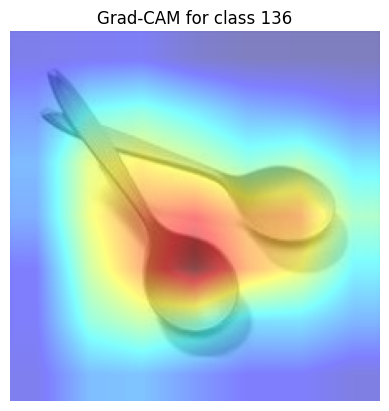

In [ ]:
cam = GradCAM(model=model, target_layers=[target_layer])
if torch.cuda.is_available():
    input_tensor = input_tensor.to(device)

outputs = model(input_tensor)
pred_class = outputs.argmax().item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]   

visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# Display
plt.imshow(visualization)
plt.title(f"Grad-CAM for class {pred_class}")
plt.axis('off')
plt.show()
